In [1]:
# Test the effect the Kilosort2 bandpass filter freq_min has on the resulting temp_wh.dat file 
# temp_wh.dat is recording that has been preprocessed https://github.com/MouseLand/Kilosort/blob/main/preProcess/preprocessDataSub.m
# Using a Juypter notebook because temp_wh.dat is VERY large and slow to load into RAM. Notebook saves variables, 
# so it does not need to be loaded each run

In [2]:
# Folder of all data files needed for analysis
root_folder = "data/maxone/mx/temp_wh_150_vs_300/"

# Parameters based on maxone_2953.dat using freq_min of 150 and 300
dat_dtype = "int16"
num_chans_total = 1020
num_chans_bad = 65  # need to be changed based on kilosort2.log
num_chans = num_chans_total - num_chans_bad

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from extract_mat import MatExtractor

In [4]:
from spikeinterface.extractors import MaxwellRecordingExtractor
data_raw = MaxwellRecordingExtractor(root_folder + "maxone_2953.raw.h5")

In [5]:
dat_filtered = np.fromfile(root_folder + "maxone_2953.dat", dtype=dat_dtype)
dat_filtered = np.reshape(dat_filtered, (-1, num_chans_total))

In [6]:
dat_150 = np.fromfile(root_folder + "150_temp_wh.dat", dtype=dat_dtype)
dat_150 = np.reshape(dat_150, (-1, num_chans))

In [7]:
# whitening_inv_150 = np.load(root_folder + "150_whitening_mat_inv.npy")
# dat_150_unwhitened = np.matmul(whitening_inv_150, dat_150.transpose((1, 0)))

In [8]:
dat_300 = np.fromfile(root_folder + "300_temp_wh.dat", dtype=dat_dtype)
dat_300 = np.reshape(dat_300, (-1, num_chans))

In [9]:
mat_150 = MatExtractor(root_folder + "150_maxone_2953_sorted.mat")
mat_300 = MatExtractor(root_folder + "300_maxone_2953_sorted.mat")
unit_150 = mat_150.get_unit(10)
unit_300 = mat_300.get_unit(12)

In [10]:
spike_times_150 = np.load(root_folder + "150_spike_times.npy").flatten()
spike_templates_150 = np.load(root_folder + "150_spike_templates.npy").flatten()
spike_times_300 = np.load(root_folder + "300_spike_times.npy").flatten()
spike_templates_300 = np.load(root_folder + "300_spike_templates.npy").flatten()

In [11]:
channel_map_150 = np.load(root_folder + "150_channel_map.npy").flatten()
channel_map_300 = np.load(root_folder + "300_channel_map.npy").flatten()

In [80]:
def array_to_dict(array: np.array):
    # Convert array to dictionary where key is a unique value and value is number of occurrences
    # {unique_value: num_occurrences}
    unique_values, counts = np.unique(array, return_counts=True)
    return dict(zip(unique_values, counts))


def find_spike_times_overlap(spike_times1, spike_times2, buffer=0):
    # Find which spikes are detected by both or only by one
    # Buffer is how off two spikes can be but still be counted as the same spike
    # E.g. if spike time is 100 and buffer is 10, spikes between [90, 110] will count as the same spike
    
    spike_times2_dict = array_to_dict(spike_times2)
    margin = range(-buffer, buffer+1)
    
    spikes_in_1_but_not_2 = []
    spikes_in_both = []  # Contains tuples of (spike time in spike_times1, spike time in spike_times2)
    from tqdm import tqdm
    for spike_time in tqdm(spike_times1):
        for m in margin:
            if (sm:=spike_time+m) in spike_times2_dict and spike_times2_dict[sm] > 0:
                spike_times2_dict[sm] -= 1
                spikes_in_both.append((spike_time, sm))
                break
        else:
            spikes_in_1_but_not_2.append(spike_time)

    spikes_in_2_but_not_1 = []
    for spike_time, count in spike_times2_dict.items():
        for _ in range(count):
            spikes_in_2_but_not_1.append(spike_time)
    return spikes_in_1_but_not_2, spikes_in_2_but_not_1, spikes_in_both
    
buffer = 0
spikes_in_150, spikes_in_300, spikes_in_both = find_spike_times_overlap(spike_times_150, spike_times_300, buffer=buffer)
print(f"Buffer: {buffer}")
print(f"Num spikes only in 150: {len(spikes_in_150)}")
print(f"Num spikes only in 300: {len(spikes_in_300)}")
print(f"Num spikes in both: {len(spikes_in_both)}")

100%|███████████████████████████████| 110127/110127 [00:00<00:00, 158055.17it/s]


Buffer: 0
Num spikes only in 150: 54545
Num spikes only in 300: 49230
Num spikes in both: 55582


In [81]:
spike_150 = spikes_in_150[0]  # 0 is good when buffer=10
spike_300 = spikes_in_300[-1]
spike_both = spikes_in_both[0]
print(f"{spike_150=}")
print(f"{spike_300=}")
print(f"{spike_both=}")

def spike_time_to_id(spike_time, spike_times_all, spike_templates):
    return spike_templates[spike_times_all.tolist().index(spike_time)]


spike_150_id = spike_time_to_id(spike_150, spike_times_150, spike_templates_150)
spike_300_id = spike_time_to_id(spike_300, spike_times_300, spike_templates_300)

# spike_both_150_id = spike_time_to_id(spike_both, spike_times_150, spike_templates_150)
# spike_both_300_id = spike_time_to_id(spike_both, spike_times_300, spike_templates_300)

print()
print(f"{spike_150_id=}")
print(f"{spike_300_id=}")
# print(f"{spike_both_150_id=}")
# print(f"{spike_both_300_id=}")

spike_150=494
spike_300=3597461
spike_both=(1189, 1189.0)

spike_150_id=706
spike_300_id=652


In [82]:
templates_150 = np.load(root_folder + "150_templates.npy")
templates_300 = np.load(root_folder + "300_templates.npy")

In [83]:
def analyze_dat_difference(spike_time, template, is_150=True, nbefore=100, nafter=100):
    """
    Plot different graphs to visualize the effect different temp_wh.dat files have on detecting spikes
    
    Paramaters
    ----------
    spike_time: int
        Time of the spike (in samples)
    template: np.array with shape (n_samples, n_channels)
        Template used to extract spike (take from Kilosort2's output templates.npy or from waveforms stored in .npy files)
    is_150: bool
        If True, the spike_time and template is from temp_wh.dat using 150Hz filter. 
        If False, the spike_time and template is from temp_wh.dat using 300Hz filter
    nbefore: int
        Number of samples to include before spike time
    nafter: int
        Number of samples to include after spike time ( +1 since slice is [inclusive, exclusive) )
    """
    spike_time = int(spike_time)

    if is_150:
        chan_max_150 = template.min(axis=0).argmin()
        chan_max_raw = channel_map_150[chan_max_150] 
        chan_max_300 = np.flatnonzero(channel_map_300 == chan_max_raw)[0]
        chan_template = chan_max_150
    else:
        chan_max_300 = template.min(axis=0).argmin()
        chan_max_raw = channel_map_300[chan_max_300]
        chan_max_150 = np.flatnonzero(channel_map_150 == chan_max_raw)[0]
        chan_template = chan_max_300
    
    
    x_max = nbefore+nafter
    window_start = spike_time-nbefore
    window_end = spike_time+nafter
    window = slice(window_start, window_end)
    spike_line_kwargs = {"x": nbefore, "color": "#000000", "alpha":0.6, "linestyle":"--", "label":"spike"}
    
    plt.title("maxone_2953.raw.h5")
    traces_raw = data_raw.get_traces(start_frame=window_start, end_frame=window_end)
    plt.axvline(**spike_line_kwargs)
    plt.plot(traces_raw[:, chan_max_raw])
    plt.legend()
    plt.xlim(0, x_max)
    plt.show()

    plt.title("Python 300hz-6000hz Bandpass Filter")
    plt.axvline(**spike_line_kwargs)
    plt.plot(dat_filtered[window, chan_max_raw])
    plt.xlim(0, x_max)
    plt.legend()
    plt.show()

    plt.title("Template")
    template_max = template[:, chan_template] / data_raw.get_channel_gains()[chan_max_raw]
    if template_max.size > x_max:
        center = template_max.size // 2
        plt.plot(template_max[center-nbefore: center+nbefore])
    elif template_max.size < x_max:
        left_pad = (x_max - template_max.size)//2
        plt.plot(np.arange(left_pad, left_pad+template_max.size), template_max)
    else:
        plt.plot(template_max)
    plt.axvline(**spike_line_kwargs)
    plt.xlim(0, x_max)
    plt.legend()
    plt.show()

    skip = 1020 # dat_150.shape[0] - data_raw.get_num_frames()
    window = slice(window_start+skip, window_end+skip)
    plt.title("Kilosort2 .dat after Preprocessing")
    plt.plot(dat_150[window, chan_max_150], label="150Hz", color="#ff9900")
    plt.plot(dat_300[window, chan_max_300], label="300Hz", color="#aa00ff")
    plt.axvline(**spike_line_kwargs)
    plt.xlim(0, x_max)
    plt.ylim(-75, 75)
    plt.legend()
    plt.show()

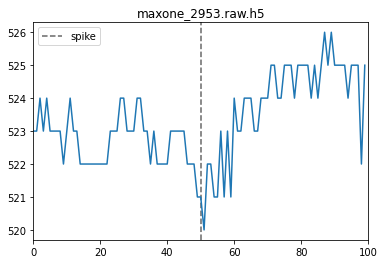

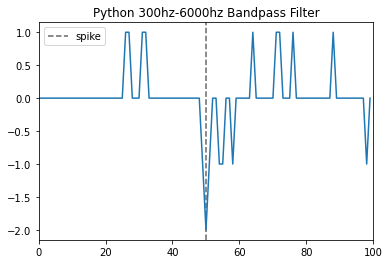

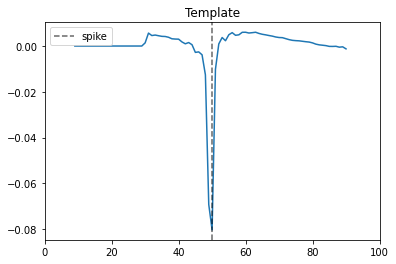

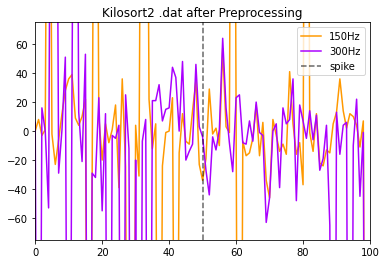

In [85]:
nbefore = nafter = 50
analyze_dat_difference(spike_150, templates_150[spike_150_id], is_150=True, nbefore=nbefore, nafter=nafter)
# analyze_dat_difference(spike_300, templates_300[spike_300_id], is_150=False, nbefore=nbefore, nafter=nafter)

In [17]:
print(np.unique(spike_templates_150).shape[0]-np.unique(spike_templates_300).shape[0])

73


In [171]:
np.unique(spike_templates_150).shape

(705,)